#Learning Topics in The Daily Kos with the Hierarchical Dirichlet Process

The Hierarchical Dirichlet Process (HDP) is typically used for topic modeling when the number of topics is unknown

Let's explore the topics of the political blog, The Daily Kos using data from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Bag+of+Words).

In [8]:
import itertools
import pyLDAvis
import pandas as pd
import re
import simplejson
import seaborn as sns

from microscopes.common.rng import rng
from microscopes.lda.definition import model_definition
from microscopes.lda.model import initialize
from microscopes.lda import model, runner
from random import shuffle

sns.set_style('darkgrid')

%matplotlib inline

First, let's grab the data from UCI:

In [9]:
!curl http://archive.ics.uci.edu/ml/machine-learning-databases/bag-of-words/docword.kos.txt.gz | gunzip > docword.kos.txt
!head docword.kos.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1029k  100 1029k    0     0   251k      0  0:00:04  0:00:04 --:--:--  264k
3430
6906
353160
1 61 2
1 76 1
1 89 1
1 211 1
1 296 1
1 335 1
1 404 1


In [10]:
!curl http://archive.ics.uci.edu/ml/machine-learning-databases/bag-of-words/vocab.kos.txt > vocab.kos.txt
!head vocab.kos.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55467  100 55467    0     0   102k      0 --:--:-- --:--:-- --:--:--  102k
aarp
abandon
abandoned
abandoning
abb
abc
abcs
abdullah
ability
aboard


```
The format of the docword.os.txt file is 3 header lines, followed by
NNZ triples:
---
D
W
NNZ
docID wordID count
docID wordID count
docID wordID count
docID wordID count
...
docID wordID count
docID wordID count
docID wordID count
---
```

We'll process the data into a list of lists of words ready to be fed into our algorithm:

In [11]:
def parse_bag_of_words_file(docword, vocab):
    with open(vocab, "r") as f:
        kos_vocab = [word.strip() for word in f.readlines()]
        id_to_word = {i: word for i, word in enumerate(kos_vocab)}
        
    with open(docword, "r") as f:
        raw = [map(int, _.strip().split()) for _ in f.readlines()][3:]

    docs = []
    for _, grp in itertools.groupby(raw, lambda x: x[0]):
        doc = []
        for _, word_id, word_cnt in grp:
            doc += word_cnt * [id_to_word[word_id-1]]
        docs.append(doc)
    return docs

In [12]:
docs = parse_bag_of_words_file("docword.kos.txt", "vocab.kos.txt")
vocab_size = len(set(word for doc in docs for word in doc))

We must define our model before we intialize it.  In this case, we need the number of docs and the number of words. 

From there, we can initialize our model and set the hyperparameters

In [13]:
defn = model_definition(len(docs), vocab_size)
prng = rng()
kos_state = initialize(defn, docs, prng, 
                        vocab_hp=1, 
                        dish_hps={"alpha": 1, "gamma": 1})
r = runner.runner(defn, docs, kos_state)

print "number of docs:", defn.n, "vocabulary size:", defn.v

number of docs: 3430 vocabulary size: 6906


Given the size of the dataset, it'll take some time to run.

We'll run our model for 1000 iterations and save our results every 25 iterations.

In [14]:
%%time
step_size = 50
steps = 500 / step_size

print "randomly initialized model:", "perplexity:", kos_state.perplexity(), "num topics:", kos_state.ntopics()
for s in range(steps):
    r.run(prng, step_size)
    print "iteration:", (s + 1) * step_size, "perplexity:", kos_state.perplexity(), "num topics:", kos_state.ntopics()

randomly initialized model: perplexity: 6908.4715103 num topics: 9
iteration: 50 perplexity: 1598.39864229 num topics: 11
iteration: 100 perplexity: 1596.41955121 num topics: 10
iteration: 150 perplexity: 1595.46606021 num topics: 13
iteration: 200 perplexity: 1595.37884448 num topics: 13
iteration: 250 perplexity: 1594.62766582 num topics: 15
iteration: 300 perplexity: 1593.20778957 num topics: 13
iteration: 350 perplexity: 1593.33655869 num topics: 13
iteration: 400 perplexity: 1594.04173705 num topics: 12
iteration: 450 perplexity: 1593.69280297 num topics: 13
iteration: 500 perplexity: 1591.68092144 num topics: 13
CPU times: user 54min 2s, sys: 17.9 s, total: 54min 20s
Wall time: 3h 44min 14s


[pyLDAvis](https://github.com/bmabey/pyLDAvis) is a Python implementation of the [LDAvis](https://github.com/cpsievert/LDAvis) tool created by [Carson Sievert](https://github.com/cpsievert). 

> LDAvis is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization.



In [15]:
prepared = pyLDAvis.prepare(**kos_state.pyldavis_data())
pyLDAvis.display(prepared)

/Users/4d/anaconda/lib/python2.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:107: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -4.08275573278e-05 and the largest is 0.127478409012.
  RuntimeWarning


## Other Functionality

### Model Serialization

LDA `state` objects are fully serializable with Pickle and cPickle. 

In [16]:
import cPickle as pickle

with open('kos_state.pkl','wb') as f:
    pickle.dump(kos_state, f)
    
with open('kos_state.pkl','rb') as f:
    new_state = pickle.load(f)

In [17]:
kos_state.assignments() == new_state.assignments()

True

In [18]:
kos_state.dish_assignments() == new_state.dish_assignments()

True

In [19]:
kos_state.table_assignments() == new_state.table_assignments()

True

### Term Relevance

We can generate term relevances (as defined by [Sievert and Shirley 2014](http://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf)) for each topic. 

In [20]:
relevance = kos_state.term_relevance_by_topic()

Here are the ten most relevant words for each topic:

In [21]:
for topics in relevance:
    words = [word for word, _ in topics[:10]]
    print ' '.join(words)

ballot nader florida signatures registration election gotv naders county nevada
iraq war iraqi military troops soldiers saddam american baghdad forces
commission documents investigation administration committee records white rice delay testimony
dean kerry edwards poll clark percent iowa gephardt primary results
bush kerry president campaign media john people debate bushs general
senate elections race district seat republican money house gop million
november account electoral governor sunzoo contact password faq login dkosopedia
tax jobs health billion budget economic deficit cuts spending taxes
marriage party gay amendment rights unions union ban abortion civil
science space reagan scientists reagans cell species researchers cells film
wink axelrod indymedia williams movies sports oreilly worship freeper consultant
photograph shakes hawk funeral pittsburgh fort flow crash rose zahn
mcdonalds stella liebeck coffee lawsuits burns degrees identifying restaurant skin


### Topic Prediction 

We can also predict how the topics with be distributed within an arbitrary document.

Let's create a document from the 100 most relevant words in the 7th topic.

In [22]:
doc = [word for word, _ in relevance[6][:100]]
shuffle(doc)
print ' '.join(doc)

parecommend racine menu vote con kossacks montclair homepage scoop sunzoo voted culture blast barbero bloomfield voting november password duderino boxfeed_listing voter governor labor bushsux admin materiel mich experience trouble store boxblogroll protests create openhttpwwwedwardsforprezcomdailykoshtml poll boxrdf_feeds consistent turnout account challengers meter login asap cities contact dem polls republicansforkerry function username needed select hstewart midday section var recommended economy tradesports altsite stolen hotshotxi faq qaqaa senate house republicans ground challenging philly endspan startspan profile liberalrakkasan dkosopedia challenger calculator exit christopher powered watchers chemical electoral challenge newwindow advertising idetestthispres updated soldier split calistan virginiadem locations crooks straight races steal ticket ourcongressorg dryfly


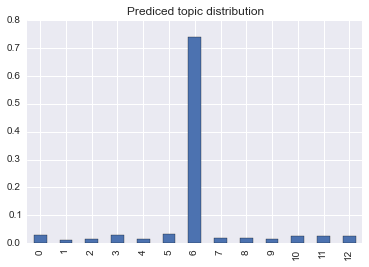

In [23]:
pd.Series(kos_state.predict(doc, r)[0]).plot(kind='bar').set_title('Prediced topic distribution')

The prediction is that this document is mostly generated by topic 7.

Similarly, if we create a document from words from the 1st and 7th topic, our prediction is that the document is generated mostly by those topics.

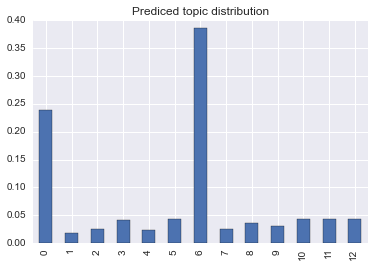

In [24]:
doc = [word for word, _ in relevance[0][:100]] + [word for word, _ in relevance[6][:100]]
shuffle(doc)
pd.Series(kos_state.predict(doc, r)[0]).plot(kind='bar').set_title('Prediced topic distribution')

### Topic and Term Distributions

Of course, we can also get the topic distribution for each document (commonly called $\Theta$).

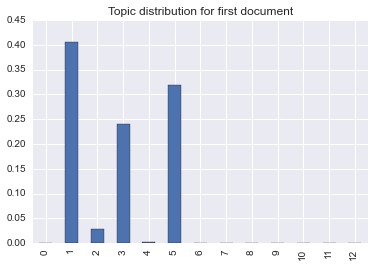

In [25]:
pd.Series(kos_state.topic_distribution_by_document()[0]).plot(kind='bar').set_title('Topic distribution for first document')

We can also get the raw word distribution for each topic (commonly called $\Phi$). This is related to the _word relevance_. Here are the most common words in one of the topics.

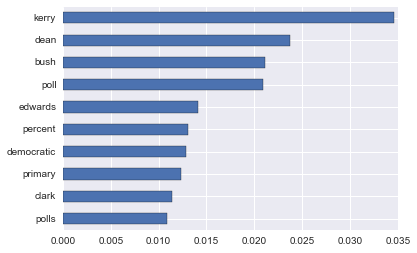

In [26]:
pd.Series(kos_state.word_distribution_by_topic()[3]).sort(inplace=False).tail(10).plot(kind='barh')